<a href="https://www.kaggle.com/code/hvvsathwik/amazon-sentiment?scriptVersionId=220100964" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install fireducks

In [ ]:
# For data manipulation and analysis
import fireducks.pandas as pd  # Using FireDucks for faster DataFrame operations

# For text preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# For feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer

# For model training and evaluation
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')


In [6]:
# Path to the training file
file_path = '/kaggle/input/amazonreviews/train.ft.txt.bz2'

# Read the compressed file
data = pd.read_csv(file_path, sep='\t', header=None, names=['text'], compression='bz2')

# Inspect the dataset
print("Dataset Preview:")
print(data.head())
print(f"Total records: {len(data)}")

Dataset Preview:
                                                text
0  __label__2 Stuning even for the non-gamer: Thi...
1  __label__2 The best soundtrack ever to anythin...
2  __label__2 Amazing!: This soundtrack is my fav...
3  __label__2 Excellent Soundtrack: I truly like ...
4  __label__2 Remember, Pull Your Jaw Off The Flo...
Total records: 3600000


In [7]:
# Extract labels and reviews from the text
data['label'] = data['text'].str.extract(r'__label__(\d)').astype(int)
data['review_text'] = data['text'].str.replace(r'__label__\d ', '', regex=True)

# Map labels into three categories (1 = Negative, 2 = Positive, 3 = Neutral if present)
label_mapping = {1: "Negative", 2: "Positive", 3: "Neutral"}
data['label'] = data['label'].map(label_mapping)

# Retain only relevant columns
data = data[['review_text', 'label']]

# Preview the cleaned data
print("Cleaned Dataset Preview:")
print(data.head())


Cleaned Dataset Preview:
                                         review_text     label
0  Stuning even for the non-gamer: This sound tra...  Positive
1  The best soundtrack ever to anything.: I'm rea...  Positive
2  Amazing!: This soundtrack is my favorite music...  Positive
3  Excellent Soundtrack: I truly like this soundt...  Positive
4  Remember, Pull Your Jaw Off The Floor After He...  Positive


Class Distribution:
label
Positive    1800000
Negative    1800000
Name: count, dtype: int64


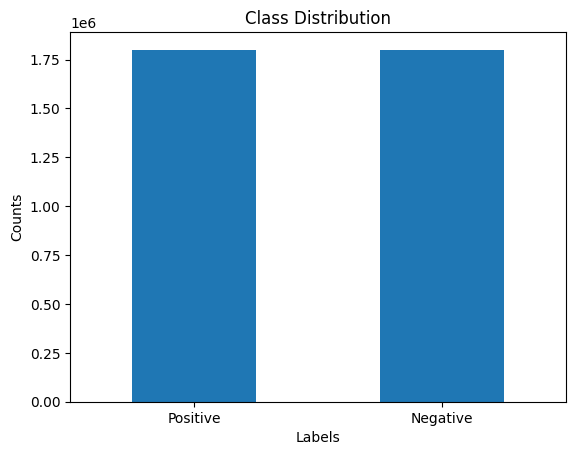

In [10]:
import matplotlib.pyplot as plt

# Display class distribution
class_counts = data['label'].value_counts()
print("Class Distribution:")
print(class_counts)

# Plot class distribution
class_counts.plot(kind='bar', title='Class Distribution')
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.xticks(rotation=0)  # Optional: Rotate x-axis labels to avoid overlap if needed
plt.show()  # Ensure this is called to display the plot


In [ ]:
!pip install spacy nltk
!python -m spacy download en_core_web_sm

In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')  # Optional, for multilingual WordNet support

In [ ]:
import spacy

try:
    spacy.require_gpu()
    print("spaCy GPU enabled.")
except:
    print("GPU not available. Using CPU.")
    
nlp = spacy.load("en_core_web_sm")


In [ ]:
!pip install -U torch


In [ ]:
!pip install gputil


In [ ]:
!nvidia-smi

In [ ]:
import time
import os
import logging
from tqdm import tqdm
import zipfile
import fireducks.pandas as pd
from spacy import load
from spacy.cli import download
import torch
import tensorflow as tf

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')
logger = logging.getLogger()

# Function for batch preprocessing with lemmatization
def preprocess_in_batches(texts, nlp):
    docs = nlp.pipe(texts, batch_size=2000)  # Batch processing for efficiency
    return [' '.join([token.lemma_ for token in doc if token.is_alpha and not token.is_stop]) for doc in docs]

# Chunked preprocessing function
def process_in_chunks(data, nlp, chunk_size=50000, save_path="/kaggle/working/processed_chunk"):
    total_rows = len(data)
    start_time = time.time()

    # Ensure the save path exists
    if not os.path.exists(save_path):
        os.makedirs(save_path)  # Create the directory if it doesn't exist

    # Process data in chunks
    for start in range(0, total_rows, chunk_size):
        chunk_start_time = time.time()
        end = min(start + chunk_size, total_rows)
        logger.info(f"Processing rows {start} to {end}...")

        # Extract the current chunk
        chunk = data.iloc[start:end].copy()  # Use `.iloc` for slicing

        # Batch process the reviews
        chunk['cleaned_review'] = preprocess_in_batches(chunk['review'], nlp)

        # Save the processed chunk
        chunk_save_path = f"{save_path}/processed_chunk_{start}_{end}.csv"
        chunk.to_csv(chunk_save_path, index=False)
        logger.info(f"Saved processed chunk to {chunk_save_path}.")
        logger.info(f"Chunk {start} to {end} processed in {time.time() - chunk_start_time:.2f} seconds.")

    logger.info(f"Total processing time: {time.time() - start_time:.2f} seconds.")

# Option to zip all processed chunks after completion
def zip_processed_chunks(save_path="/kaggle/working/processed_chunk"):
    zip_file = "/kaggle/working/processed_chunks.zip"
    with zipfile.ZipFile(zip_file, 'w') as zipf:
        for file in os.listdir(save_path):
            if file.startswith("processed_chunk_"):
                zipf.write(os.path.join(save_path, file), arcname=file)
    logger.info(f"Processed chunks zipped into {zip_file}")
    return zip_file

# Main script
if __name__ == "__main__":
    try:
        # Enable GPU usage for spaCy if available
        import spacy
        spacy.prefer_gpu()
        logger.info("spaCy is configured to use GPU if available.")

        # Check if PyTorch and TensorFlow can utilize GPU
        if torch.cuda.is_available():
            device = torch.device("cuda")
            logger.info(f"PyTorch GPU detected: {torch.cuda.get_device_name(device)}")
        else:
            device = torch.device("cpu")
            logger.info("PyTorch is using CPU.")

        if len(tf.config.list_physical_devices('GPU')) > 0:
            logger.info(f"TensorFlow GPU detected: {tf.config.list_physical_devices('GPU')}")
        else:
            logger.info("TensorFlow is using CPU.")

        # Download and load the spaCy model
        try:
            nlp = load("en_core_web_sm", disable=["ner", "parser"])
        except OSError:
            logger.info("Downloading spaCy model...")
            download("en_core_web_sm")
            nlp = load("en_core_web_sm", disable=["ner", "parser"])

        # Paths
        file_path = '/kaggle/input/amazonreviews/train.ft.txt.bz2'
        save_path = "/kaggle/working/processed_chunk"

        # Load the dataset
        logger.info("Loading dataset...")
        data = pd.read_csv(file_path, sep='\t', header=None, names=['text'], compression='bz2')

        # Extract labels and reviews
        logger.info("Extracting labels and reviews...")
        data['label'] = data['text'].apply(lambda x: int(x.split()[0].replace('__label__', '')))
        data['review'] = data['text'].apply(lambda x: ' '.join(x.split()[1:]))
        data = data[['review', 'label']]  # Retain only relevant columns

        # Start preprocessing
        logger.info("Starting preprocessing...")
        process_in_chunks(data, nlp, chunk_size=50000, save_path=save_path)

        # Optionally, zip processed chunks after processing is done
        logger.info("Zipping processed chunks...")
        zip_file = zip_processed_chunks(save_path=save_path)
        logger.info(f"Zipped file location: {zip_file}")

    except Exception as e:
        logger.error(f"An error occurred: {e}")


# ***After Preprocessing***

In [2]:
import fireducks.pandas as pd
import os

# Path to the extracted chunk files (from your Kaggle dataset structure)
extracted_chunks_path = "/kaggle/input/processed-chunks-1"  # Adjust if the path differs

# Combine all chunk files
all_chunks = []
for file_name in sorted(os.listdir(extracted_chunks_path)):  # Ensure files are combined in order
    if file_name.startswith("processed_chunk_") and file_name.endswith(".csv"):
        file_path = os.path.join(extracted_chunks_path, file_name)
        print(f"Loading {file_name}...")
        chunk = pd.read_csv(file_path)
        all_chunks.append(chunk)

# Concatenate all chunks into a single DataFrame
combined_data = pd.concat(all_chunks, ignore_index=True)

# Display combined data info
print("Combined data shape:", combined_data.shape)


Loading processed_chunk_0_50000.csv...
Loading processed_chunk_1000000_1050000.csv...
Loading processed_chunk_100000_150000.csv...
Loading processed_chunk_1050000_1100000.csv...
Loading processed_chunk_1100000_1150000.csv...
Loading processed_chunk_1150000_1200000.csv...
Loading processed_chunk_1200000_1250000.csv...
Loading processed_chunk_1250000_1300000.csv...
Loading processed_chunk_1300000_1350000.csv...
Loading processed_chunk_1350000_1400000.csv...
Loading processed_chunk_1400000_1450000.csv...
Loading processed_chunk_1450000_1500000.csv...
Loading processed_chunk_1500000_1550000.csv...
Loading processed_chunk_150000_200000.csv...
Loading processed_chunk_1550000_1600000.csv...
Loading processed_chunk_1600000_1650000.csv...
Loading processed_chunk_1650000_1700000.csv...
Loading processed_chunk_1700000_1750000.csv...
Loading processed_chunk_1750000_1800000.csv...
Loading processed_chunk_1800000_1850000.csv...
Loading processed_chunk_1850000_1900000.csv...
Loading processed_chunk_1

In [3]:
# Save the combined dataset as a CSV for future use
combined_data_path = "/kaggle/working/combined_processed_data.csv"
combined_data.to_csv(combined_data_path, index=False)
print(f"Combined data saved at: {combined_data_path}")


Combined data saved at: /kaggle/working/combined_processed_data.csv


In [4]:
# Load the saved combined dataset
combined_data = pd.read_csv("/kaggle/working/combined_processed_data.csv")

# Check the dataset structure
print(combined_data.info())
print(combined_data.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600000 entries, 0 to 3599999
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   review          object
 1   label           int64 
 2   cleaned_review  object
dtypes: int64(1), object(2)
memory usage: 82.4+ MB
None
                                              review  label  \
0  Stuning even for the non-gamer: This sound tra...      2   
1  The best soundtrack ever to anything.: I'm rea...      2   
2  Amazing!: This soundtrack is my favorite music...      2   
3  Excellent Soundtrack: I truly like this soundt...      2   
4  Remember, Pull Your Jaw Off The Floor After He...      2   

                                      cleaned_review  
0  stun non gamer sound track beautiful paint sen...  
1  good soundtrack read lot review say good game ...  
2  amazing soundtrack favorite music time hand in...  
3  excellent soundtrack truly like soundtrack enj...  
4  remember pull Jaw Floor hear play g

In [5]:
# Check label distribution
print(combined_data['label'].value_counts())

label
2    1800000
1    1800000
Name: count, dtype: int64


In [6]:
from sklearn.model_selection import train_test_split

# Split the data into train and test sets
X = combined_data['cleaned_review']  # Features (cleaned reviews)
y = combined_data['label']           # Labels (1 for neutral, 2 for positive)

# Perform train-test split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

Training samples: 2880000
Testing samples: 720000


# Hashing Vectorizer or Feature Engineering 

In [7]:
from sklearn.feature_extraction.text import HashingVectorizer
from scipy.sparse import vstack
from sklearn.model_selection import train_test_split

# Ensure that 'combined_data['label']' contains 0 for negative, 1 for neutral, and 2 for positive
X = combined_data['cleaned_review']  # Features (cleaned reviews)
y = combined_data['label']           # Labels (0 for negative, 1 for neutral, 2 for positive)

# Perform train-test split (90% training, 10% testing) with a reduced test size
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

# Use HashingVectorizer for incremental vectorization
hash_vectorizer = HashingVectorizer(n_features=5000, alternate_sign=False, ngram_range=(1, 2))

# Batch processing function for HashingVectorizer
def batch_hash_transform(vectorizer, data, batch_size=100000):
    """Batch process large datasets for HashingVectorizer transformation."""
    batches = []
    total = len(data)
    for i in range(0, total, batch_size):
        print(f"Processing batch {i // batch_size + 1} / {total // batch_size + 1}")
        batch = data[i: i + batch_size].values.astype('U')  # Convert to Unicode
        batches.append(vectorizer.transform(batch))
    return vstack(batches)

# Transform training data in batches
print("Starting HashingVectorizer transformation on training data...")
X_train_tfidf = batch_hash_transform(hash_vectorizer, X_train, batch_size=50000)

# Transform testing data in batches
print("Starting HashingVectorizer transformation on testing data...")
X_test_tfidf = batch_hash_transform(hash_vectorizer, X_test, batch_size=50000)

print("HashingVectorizer transformation complete.")
print(f"Training Hashing shape: {X_train_tfidf.shape}")
print(f"Testing Hashing shape: {X_test_tfidf.shape}")


Training samples: 3240000
Testing samples: 360000
Starting HashingVectorizer transformation on training data...
Processing batch 1 / 65
Processing batch 2 / 65
Processing batch 3 / 65
Processing batch 4 / 65
Processing batch 5 / 65
Processing batch 6 / 65
Processing batch 7 / 65
Processing batch 8 / 65
Processing batch 9 / 65
Processing batch 10 / 65
Processing batch 11 / 65
Processing batch 12 / 65
Processing batch 13 / 65
Processing batch 14 / 65
Processing batch 15 / 65
Processing batch 16 / 65
Processing batch 17 / 65
Processing batch 18 / 65
Processing batch 19 / 65
Processing batch 20 / 65
Processing batch 21 / 65
Processing batch 22 / 65
Processing batch 23 / 65
Processing batch 24 / 65
Processing batch 25 / 65
Processing batch 26 / 65
Processing batch 27 / 65
Processing batch 28 / 65
Processing batch 29 / 65
Processing batch 30 / 65
Processing batch 31 / 65
Processing batch 32 / 65
Processing batch 33 / 65
Processing batch 34 / 65
Processing batch 35 / 65
Processing batch 36 / 

In [8]:
import joblib

# Save the HashingVectorizer
joblib.dump(hash_vectorizer, '/kaggle/working/hashing_vectorizer.pkl')


['/kaggle/working/hashing_vectorizer.pkl']

In [9]:
print(combined_data['label'].value_counts())

label
2    1800000
1    1800000
Name: count, dtype: int64


 # Model-1
> XGBOOST

In [ ]:
from xgboost import DMatrix, XGBClassifier, cv
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import StratifiedKFold
import numpy as np

# Adjust target labels to be 0-based
y_train_adjusted = y_train - 1
y_test_adjusted = y_test - 1

# Convert training data to DMatrix
dtrain = DMatrix(X_train_tfidf, label=y_train_adjusted)

# Define hyperparameter grid
learning_rates = [0.01, 0.05, 0.1]
n_estimators_values = [100, 200, 500]
max_depth_values = [3, 5, 7]
min_child_weight_values = [1, 5, 10]
gamma_values = [0, 0.1, 0.2]

# Cross-validation setup
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Iterate over hyperparameters
for lr in learning_rates:
    for n_est in n_estimators_values:
        for max_depth in max_depth_values:
            for min_child_weight in min_child_weight_values:
                for gamma in gamma_values:
                    print(f"Training XGBoost classifier with learning_rate={lr}, n_estimators={n_est}, max_depth={max_depth}, min_child_weight={min_child_weight}, gamma={gamma}...")

                    # Set up the XGBoost model with regularization and early stopping
                    xgb_classifier = XGBClassifier(
                        learning_rate=lr,
                        n_estimators=n_est,
                        max_depth=max_depth,
                        min_child_weight=min_child_weight,
                        gamma=gamma,
                        use_label_encoder=False,
                        eval_metric='logloss',  # Set eval_metric here
                        tree_method='hist',
                        device='cuda',  # Specify GPU for training
                    )

                    # Cross-validation to monitor the model's generalization
                    cv_results = cv(
                        dtrain=dtrain, 
                        params=xgb_classifier.get_params(), 
                        num_boost_round=n_est, 
                        nfold=5, 
                        early_stopping_rounds=10,  # Early stopping if performance doesn't improve
                        metrics='logloss', 
                        as_pandas=True,
                        seed=42
                    )

                    # Best iteration (round) from cross-validation results
                    best_iter = cv_results['test-logloss-mean'].idxmin()
                    print(f"Best round from CV: {best_iter}")

                    # Define a validation set for early stopping
                    eval_set = [(X_train_tfidf, y_train_adjusted), (X_test_tfidf, y_test_adjusted)]

                    # Train the model with the best number of rounds and provide the validation set
                    xgb_classifier.fit(X_train_tfidf, y_train_adjusted, early_stopping_rounds=10, eval_set=eval_set)

                    print("Predicting with XGBoost...")
                    y_pred_xgb = xgb_classifier.predict(X_test_tfidf)

                    # Adjust predictions back to the original label scale for reporting
                    y_pred_xgb_original = y_pred_xgb + 1

                    # Performance reporting
                    print(f"XGBoost Classification Report for learning_rate={lr}, n_estimators={n_est}, max_depth={max_depth}, min_child_weight={min_child_weight}, gamma={gamma}:")
                    print(classification_report(y_test, y_pred_xgb_original))
                    accuracy = accuracy_score(y_test, y_pred_xgb_original)
                    print(f"XGBoost Accuracy with learning_rate={lr}, n_estimators={n_est}, max_depth={max_depth}, min_child_weight={min_child_weight}, gamma={gamma}: {accuracy:.4f}\n")


* # **LightGBM**

In [10]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score
import psutil
import numpy as np

# Function to check memory usage
def check_memory():
    print(f"Memory usage: {psutil.virtual_memory().percent}%")

# Adjust target labels to be 0-based
y_train_adjusted = y_train - 1
y_test_adjusted = y_test - 1

# Convert labels to numpy arrays
y_train_adjusted = np.array(y_train_adjusted)
y_test_adjusted = np.array(y_test_adjusted)

# Define hyperparameter grid for LightGBM (with smaller iterations)
learning_rates = [0.01, 0.05]
iterations_values = [50, 100]  # Reduced iterations
depth_values = [3, 5]
num_leaves_values = [15, 31]

# Cross-validation setup (reduced folds to save memory)
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)  # 3 folds

# Iterate over hyperparameters
for lr in learning_rates:
    for iterations in iterations_values:
        for depth in depth_values:
            for num_leaves in num_leaves_values:
                print(f"Training LightGBM classifier with learning_rate={lr}, iterations={iterations}, depth={depth}, num_leaves={num_leaves}...")

                # Set up the LightGBM model with the specified hyperparameters
                lgbm_classifier = lgb.LGBMClassifier(
                    learning_rate=lr,
                    n_estimators=iterations,
                    max_depth=depth,
                    num_leaves=num_leaves,
                    verbose=-1,
                    n_jobs=-1  # Use all available CPU cores
                )

                # Cross-validation setup
                lgbm_classifier.fit(X_train_tfidf[:10000], y_train_adjusted[:10000])  # Use a smaller subset
                y_pred_lgbm = lgbm_classifier.predict(X_test_tfidf)

                # Adjust predictions back to the original label scale for reporting
                y_pred_lgbm_original = y_pred_lgbm + 1

                # Performance reporting
                print(f"LightGBM Classification Report for learning_rate={lr}, iterations={iterations}, depth={depth}, num_leaves={num_leaves}:")
                print(classification_report(y_test, y_pred_lgbm_original))
                accuracy = accuracy_score(y_test, y_pred_lgbm_original)
                print(f"LightGBM Accuracy: {accuracy:.4f}\n")

                # Check memory usage after each iteration
                check_memory()


Training LightGBM classifier with learning_rate=0.01, iterations=50, depth=3, num_leaves=15...
LightGBM Classification Report for learning_rate=0.01, iterations=50, depth=3, num_leaves=15:
              precision    recall  f1-score   support

           1       0.68      0.73      0.70    180000
           2       0.71      0.65      0.68    180000

    accuracy                           0.69    360000
   macro avg       0.69      0.69      0.69    360000
weighted avg       0.69      0.69      0.69    360000

LightGBM Accuracy: 0.6916

Memory usage: 46.9%
Training LightGBM classifier with learning_rate=0.01, iterations=50, depth=3, num_leaves=31...
LightGBM Classification Report for learning_rate=0.01, iterations=50, depth=3, num_leaves=31:
              precision    recall  f1-score   support

           1       0.68      0.73      0.70    180000
           2       0.71      0.65      0.68    180000

    accuracy                           0.69    360000
   macro avg       0.69      0

* # **CatBoost**

In [1]:
from catboost import CatBoostClassifier, cv, Pool
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
from sklearn.model_selection import StratifiedKFold
import psutil

# Function to check memory usage
def check_memory():
    print(f"Memory usage: {psutil.virtual_memory().percent}%")

# Adjust target labels to be 0-based
y_train_adjusted = y_train - 1
y_test_adjusted = y_test - 1

# Convert labels to numpy arrays
y_train_adjusted = np.array(y_train_adjusted)
y_test_adjusted = np.array(y_test_adjusted)

# Define hyperparameter grid for CatBoost (with smaller iterations)
learning_rates = [0.01, 0.05]
iterations_values = [50, 100]  # Reduced iterations
depth_values = [3, 5]
l2_leaf_reg_values = [1, 3]
border_count_values = [32, 50]

# Cross-validation setup (reduced folds to save memory)
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)  # 3 folds

# Iterate over hyperparameters
for lr in learning_rates:
    for iterations in iterations_values:
        for depth in depth_values:
            for l2_leaf_reg in l2_leaf_reg_values:
                for border_count in border_count_values:
                    print(f"Training CatBoost classifier with learning_rate={lr}, iterations={iterations}, depth={depth}, l2_leaf_reg={l2_leaf_reg}, border_count={border_count}...")

                    # Set up the CatBoost model with the specified hyperparameters
                    catboost_classifier = CatBoostClassifier(
                        learning_rate=lr,
                        iterations=iterations,
                        depth=depth,
                        l2_leaf_reg=l2_leaf_reg,
                        border_count=border_count,
                        verbose=0,  # To suppress verbose output
                        thread_count=-1  # Use all available CPU cores
                    )

                    # Prepare data as Pool objects for CatBoost
                    train_pool = Pool(X_train_tfidf[:10000], label=y_train_adjusted[:10000])  # Use a smaller subset
                    test_pool = Pool(X_test_tfidf, label=y_test_adjusted)

                    # Cross-validation to monitor the model's generalization
                    params = catboost_classifier.get_params()
                    params['eval_metric'] = 'Accuracy'  # Specify metric for evaluation
                    params['loss_function'] = 'Logloss'  # Specify the loss function

                    cv_results = cv(
                        pool=train_pool,  # Provide the training data in Pool format
                        params=params,  # Pass model parameters
                        num_boost_round=iterations, 
                        nfold=3,  # Reduced folds to save memory
                        early_stopping_rounds=10,  # Early stopping if performance doesn't improve
                        as_pandas=True,
                        seed=42
                    )

                    # Best iteration (round) from cross-validation results
                    best_iter = cv_results['test-Accuracy-mean'].idxmax()  # Best round based on accuracy
                    print(f"Best round from CV: {best_iter}")

                    # Train the model with the best number of rounds
                    catboost_classifier.fit(X_train_tfidf, y_train_adjusted, verbose=0)

                    print("Predicting with CatBoost...")
                    y_pred_catboost = catboost_classifier.predict(X_test_tfidf)

                    # Adjust predictions back to the original label scale for reporting
                    y_pred_catboost_original = y_pred_catboost + 1

                    # Performance reporting
                    print(f"CatBoost Classification Report for learning_rate={lr}, iterations={iterations}, depth={depth}, l2_leaf_reg={l2_leaf_reg}, border_count={border_count}:")
                    print(classification_report(y_test, y_pred_catboost_original))
                    accuracy = accuracy_score(y_test, y_pred_catboost_original)
                    print(f"CatBoost Accuracy with learning_rate={lr}, iterations={iterations}, depth={depth}, l2_leaf_reg={l2_leaf_reg}, border_count={border_count}: {accuracy:.4f}\n")

                    # Check memory usage after each iteration
                    check_memory()


NameError: name 'y_train' is not defined

* # **Random Forest**

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score
import psutil
import numpy as np

# Function to check memory usage
def check_memory():
    print(f"Memory usage: {psutil.virtual_memory().percent}%")

# Adjust target labels to be 0-based
y_train_adjusted = y_train - 1
y_test_adjusted = y_test - 1

# Convert labels to numpy arrays
y_train_adjusted = np.array(y_train_adjusted)
y_test_adjusted = np.array(y_test_adjusted)

# Define hyperparameter grid for RandomForest
n_estimators_values = [50, 100]
depth_values = [3, 5]
min_samples_split_values = [2, 5]

# Cross-validation setup (reduced folds to save memory)
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)  # 3 folds

# Iterate over hyperparameters
for n_estimators in n_estimators_values:
    for depth in depth_values:
        for min_samples_split in min_samples_split_values:
            print(f"Training Random Forest classifier with n_estimators={n_estimators}, depth={depth}, min_samples_split={min_samples_split}...")

            # Set up the Random Forest model with the specified hyperparameters
            rf_classifier = RandomForestClassifier(
                n_estimators=n_estimators,
                max_depth=depth,
                min_samples_split=min_samples_split,
                n_jobs=-1,  # Use all available CPU cores
                random_state=42
            )

            # Train the model
            rf_classifier.fit(X_train_tfidf[:10000], y_train_adjusted[:10000])  # Use a smaller subset
            y_pred_rf = rf_classifier.predict(X_test_tfidf)

            # Adjust predictions back to the original label scale for reporting
            y_pred_rf_original = y_pred_rf + 1

            # Performance reporting
            print(f"Random Forest Classification Report for n_estimators={n_estimators}, depth={depth}, min_samples_split={min_samples_split}:")
            print(classification_report(y_test, y_pred_rf_original))
            accuracy = accuracy_score(y_test, y_pred_rf_original)
            print(f"Random Forest Accuracy: {accuracy:.4f}\n")

            # Check memory usage after each iteration
            check_memory()


Training Random Forest classifier with n_estimators=50, depth=3, min_samples_split=2...
Random Forest Classification Report for n_estimators=50, depth=3, min_samples_split=2:
              precision    recall  f1-score   support

           1       0.76      0.65      0.70    180000
           2       0.69      0.79      0.74    180000

    accuracy                           0.72    360000
   macro avg       0.73      0.72      0.72    360000
weighted avg       0.73      0.72      0.72    360000

Random Forest Accuracy: 0.7212

Memory usage: 47.4%
Training Random Forest classifier with n_estimators=50, depth=3, min_samples_split=5...
Random Forest Classification Report for n_estimators=50, depth=3, min_samples_split=5:
              precision    recall  f1-score   support

           1       0.76      0.65      0.70    180000
           2       0.69      0.79      0.74    180000

    accuracy                           0.72    360000
   macro avg       0.73      0.72      0.72    360000

# **AdaBoost**

In [12]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score
import psutil
import numpy as np

# Function to check memory usage
def check_memory():
    print(f"Memory usage: {psutil.virtual_memory().percent}%")

# Adjust target labels to be 0-based
y_train_adjusted = y_train - 1
y_test_adjusted = y_test - 1

# Convert labels to numpy arrays
y_train_adjusted = np.array(y_train_adjusted)
y_test_adjusted = np.array(y_test_adjusted)

# Define hyperparameter grid for AdaBoost
n_estimators_values = [50, 100]
learning_rate_values = [0.01, 0.1]

# Cross-validation setup (reduced folds to save memory)
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)  # 3 folds

# Iterate over hyperparameters
for n_estimators in n_estimators_values:
    for learning_rate in learning_rate_values:
        print(f"Training AdaBoost classifier with n_estimators={n_estimators}, learning_rate={learning_rate}...")

        # Set up the AdaBoost model with the specified hyperparameters
        adaboost_classifier = AdaBoostClassifier(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            random_state=42
        )

        # Train the model
        adaboost_classifier.fit(X_train_tfidf[:10000], y_train_adjusted[:10000])  # Use a smaller subset
        y_pred_adaboost = adaboost_classifier.predict(X_test_tfidf)

        # Adjust predictions back to the original label scale for reporting
        y_pred_adaboost_original = y_pred_adaboost + 1

        # Performance reporting
        print(f"AdaBoost Classification Report for n_estimators={n_estimators}, learning_rate={learning_rate}:")
        print(classification_report(y_test, y_pred_adaboost_original))
        accuracy = accuracy_score(y_test, y_pred_adaboost_original)
        print(f"AdaBoost Accuracy: {accuracy:.4f}\n")

        # Check memory usage after each iteration
        check_memory()


Training AdaBoost classifier with n_estimators=50, learning_rate=0.01...
AdaBoost Classification Report for n_estimators=50, learning_rate=0.01:
              precision    recall  f1-score   support

           1       0.57      0.89      0.70    180000
           2       0.76      0.33      0.46    180000

    accuracy                           0.61    360000
   macro avg       0.67      0.61      0.58    360000
weighted avg       0.67      0.61      0.58    360000

AdaBoost Accuracy: 0.6134

Memory usage: 47.2%
Training AdaBoost classifier with n_estimators=50, learning_rate=0.1...
AdaBoost Classification Report for n_estimators=50, learning_rate=0.1:
              precision    recall  f1-score   support

           1       0.68      0.77      0.72    180000
           2       0.74      0.64      0.69    180000

    accuracy                           0.71    360000
   macro avg       0.71      0.71      0.70    360000
weighted avg       0.71      0.71      0.70    360000

AdaBoost Ac

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score
import psutil
import numpy as np

# Function to check memory usage
def check_memory():
    print(f"Memory usage: {psutil.virtual_memory().percent}%")

# Adjust target labels to be 0-based
y_train_adjusted = y_train - 1
y_test_adjusted = y_test - 1

# Convert labels to numpy arrays
y_train_adjusted = np.array(y_train_adjusted)
y_test_adjusted = np.array(y_test_adjusted)

# Define hyperparameter grid for MLP
hidden_layer_sizes_values = [(100,), (128, 64)]
activation_values = ['relu', 'tanh']
solver_values = ['adam', 'sgd']

# Cross-validation setup (reduced folds to save memory)
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)  # 3 folds

# Iterate over hyperparameters
for hidden_layer_sizes in hidden_layer_sizes_values:
    for activation in activation_values:
        for solver in solver_values:
            print(f"Training MLPClassifier with hidden_layer_sizes={hidden_layer_sizes}, activation={activation}, solver={solver}...")

            # Set up the MLPClassifier model with the specified hyperparameters
            mlp_classifier = MLPClassifier(
                hidden_layer_sizes=hidden_layer_sizes,
                activation=activation,
                solver=solver,
                max_iter=300,
                random_state=42
            )

            # Train the model
            mlp_classifier.fit(X_train_tfidf[:50000], y_train_adjusted[:50000])  # Use a larger subset
            y_pred_mlp = mlp_classifier.predict(X_test_tfidf)

            # Adjust predictions back to the original label scale for reporting
            y_pred_mlp_original = y_pred_mlp + 1

            # Performance reporting
            print(f"MLPClassifier Classification Report for hidden_layer_sizes={hidden_layer_sizes}, activation={activation}, solver={solver}:")
            print(classification_report(y_test, y_pred_mlp_original))
            accuracy = accuracy_score(y_test, y_pred_mlp_original)
            print(f"MLPClassifier Accuracy: {accuracy:.4f}\n")

            # Check memory usage after each iteration
            check_memory()


Training MLPClassifier with hidden_layer_sizes=(100,), activation=relu, solver=adam...
MLPClassifier Classification Report for hidden_layer_sizes=(100,), activation=relu, solver=adam:
              precision    recall  f1-score   support

           1       0.80      0.81      0.80    180000
           2       0.81      0.80      0.80    180000

    accuracy                           0.80    360000
   macro avg       0.80      0.80      0.80    360000
weighted avg       0.80      0.80      0.80    360000

MLPClassifier Accuracy: 0.8044

Memory usage: 46.6%
Training MLPClassifier with hidden_layer_sizes=(100,), activation=relu, solver=sgd...


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier Classification Report for hidden_layer_sizes=(100,), activation=relu, solver=sgd:
              precision    recall  f1-score   support

           1       0.83      0.81      0.82    180000
           2       0.81      0.84      0.82    180000

    accuracy                           0.82    360000
   macro avg       0.82      0.82      0.82    360000
weighted avg       0.82      0.82      0.82    360000

MLPClassifier Accuracy: 0.8221

Memory usage: 45.9%
Training MLPClassifier with hidden_layer_sizes=(100,), activation=tanh, solver=adam...


# Naive Bayes and Support Vector Machine

In [14]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score

# Naive Bayes with hyperparameter tuning
print("Naive Bayes: Experimenting with alpha values...\n")
alpha_values = [0.1, 0.5, 1.0, 2.0]
for alpha in alpha_values:
    print(f"Training Naive Bayes classifier with alpha={alpha}...")
    nb_classifier = MultinomialNB(alpha=alpha)
    nb_classifier.fit(X_train_tfidf, y_train)
    
    print("Predicting with Naive Bayes...")
    y_pred_nb = nb_classifier.predict(X_test_tfidf)
    
    print(f"Naive Bayes Classification Report for alpha={alpha}:")
    print(classification_report(y_test, y_pred_nb))
    accuracy = accuracy_score(y_test, y_pred_nb)
    print(f"Naive Bayes Accuracy with alpha={alpha}: {accuracy:.4f}\n")

# SVM with hyperparameter tuning
print("Support Vector Machine: Experimenting with C values...\n")
c_values = [0.1, 0.5, 1.0, 2.0]
for c_value in c_values:
    print(f"Training Support Vector Machine classifier with C={c_value}...")
    svm_classifier = LinearSVC(C=c_value, max_iter=5000)
    svm_classifier.fit(X_train_tfidf, y_train)
    
    print("Predicting with SVM...")
    y_pred_svm = svm_classifier.predict(X_test_tfidf)
    
    print(f"SVM Classification Report for C={c_value}:")
    print(classification_report(y_test, y_pred_svm))
    accuracy = accuracy_score(y_test, y_pred_svm)
    print(f"SVM Accuracy with C={c_value}: {accuracy:.4f}\n")


Naive Bayes: Experimenting with alpha values...

Training Naive Bayes classifier with alpha=0.1...
Predicting with Naive Bayes...
Naive Bayes Classification Report for alpha=0.1:
              precision    recall  f1-score   support

           1       0.81      0.79      0.80    180000
           2       0.80      0.82      0.81    180000

    accuracy                           0.81    360000
   macro avg       0.81      0.81      0.81    360000
weighted avg       0.81      0.81      0.81    360000

Naive Bayes Accuracy with alpha=0.1: 0.8051

Training Naive Bayes classifier with alpha=0.5...
Predicting with Naive Bayes...
Naive Bayes Classification Report for alpha=0.5:
              precision    recall  f1-score   support

           1       0.81      0.79      0.80    180000
           2       0.80      0.82      0.81    180000

    accuracy                           0.81    360000
   macro avg       0.81      0.81      0.81    360000
weighted avg       0.81      0.81      0.81    

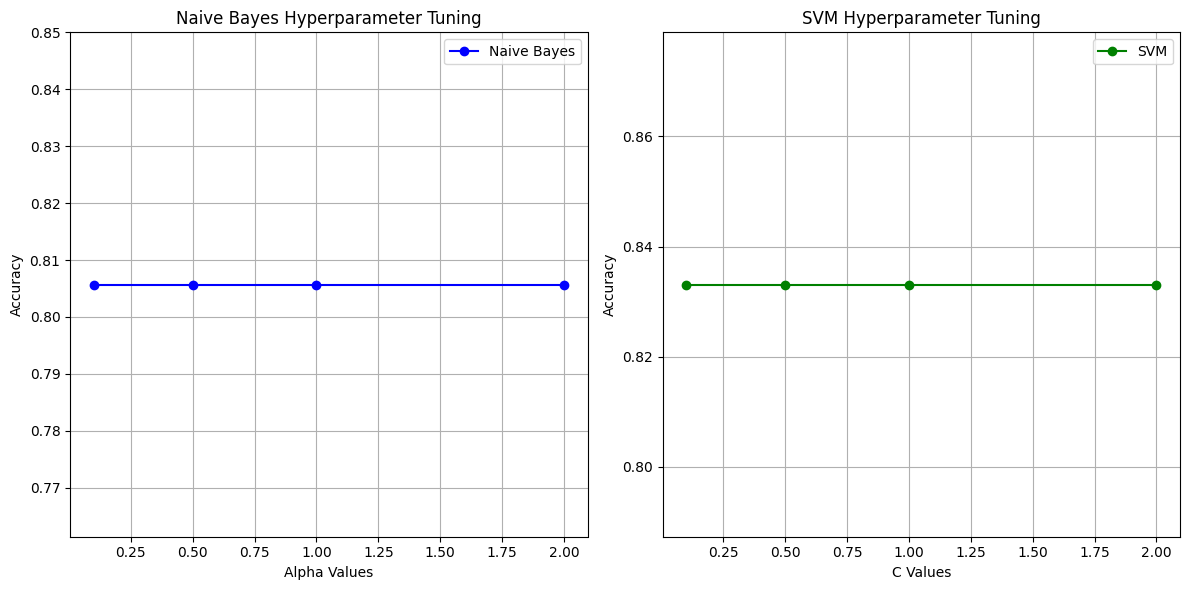

In [16]:
import matplotlib.pyplot as plt

# Store the results of accuracy for visualization
nb_accuracies = [0.8057, 0.8057, 0.8057, 0.8057]  # Replace with actual values from your output
svm_accuracies = [0.8331, 0.8331, 0.8331, 0.8331]  # Replace with actual values from your output

# Plot Naive Bayes results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(alpha_values, nb_accuracies, marker='o', color='blue', label='Naive Bayes')
plt.title("Naive Bayes Hyperparameter Tuning")
plt.xlabel("Alpha Values")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

# Plot SVM results
plt.subplot(1, 2, 2)
plt.plot(c_values, svm_accuracies, marker='o', color='green', label='SVM')
plt.title("SVM Hyperparameter Tuning")
plt.xlabel("C Values")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [17]:
import joblib

# Assume SVM with C=1.0 is the best model (replace with your best parameters)
best_svm_classifier = LinearSVC(C=1.0, max_iter=5000)
best_svm_classifier.fit(X_train_tfidf, y_train)

# Save the model
joblib.dump(best_svm_classifier, "best_svm_model.pkl")
print("Best SVM model saved as 'best_svm_model.pkl'")


Best SVM model saved as 'best_svm_model.pkl'


In [18]:
# Load the saved model
loaded_model = joblib.load("best_svm_model.pkl")

# Predict on test data
new_predictions = loaded_model.predict(X_test_tfidf)

# Evaluate the model
print("Classification Report for Best Model:")
print(classification_report(y_test, new_predictions))

accuracy = accuracy_score(y_test, new_predictions)
print(f"Accuracy of Best Model: {accuracy:.4f}")


Classification Report for Best Model:
              precision    recall  f1-score   support

           1       0.83      0.83      0.83    180000
           2       0.83      0.84      0.83    180000

    accuracy                           0.83    360000
   macro avg       0.83      0.83      0.83    360000
weighted avg       0.83      0.83      0.83    360000

Accuracy of Best Model: 0.8329


In [19]:
import spacy

# Load Spacy model for preprocessing
nlp = spacy.load("en_core_web_sm")


# **TESTING WITH UNSEEN DATA** 

In [20]:
import spacy
import joblib
import pandas as pd

# Load Spacy model for preprocessing
nlp = spacy.load("en_core_web_sm")

# Sample unseen reviews
unseen_reviews = [
    "I absolutely love this product! It's amazing.",
    "The experience was horrible and I regret buying it.",
    "Not bad, but not great either. It's average."
]

# Preprocessing function
def preprocess_review(review):
    return ' '.join([token.lemma_ for token in nlp(review) if token.is_alpha and not token.is_stop])

# Load necessary models and vectorizers
hash_vectorizer = joblib.load('/kaggle/working/hashing_vectorizer.pkl')  # Corrected file path
loaded_model = joblib.load('best_svm_model.pkl')

# Preprocess and transform unseen reviews
unseen_reviews_cleaned = [preprocess_review(review) for review in unseen_reviews]
unseen_reviews_tfidf = batch_hash_transform(hash_vectorizer, pd.Series(unseen_reviews_cleaned))

# Predict sentiments
unseen_predictions = loaded_model.predict(unseen_reviews_tfidf)

# Display predictions
for review, prediction in zip(unseen_reviews, unseen_predictions):
    sentiment = "Positive" if prediction == 2 else "Negative"
    print(f"Review: {review}\nPredicted Sentiment: {sentiment}\n")

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


Processing batch 1 / 1
Review: I absolutely love this product! It's amazing.
Predicted Sentiment: Positive

Review: The experience was horrible and I regret buying it.
Predicted Sentiment: Negative

Review: Not bad, but not great either. It's average.
Predicted Sentiment: Negative



# **Other Three Models**

In [23]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score


In [1]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import gc  # Garbage collector for memory optimization

# Ensure consistent train-test split for hashed data
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
    X_train_tfidf, y_train, test_size=0.2, random_state=42  # 80% training, 20% testing
)

# Re-map y_train and y_test labels to binary (0 and 1) for binary classification
y_train_split = y_train_split - 1
y_test_split = y_test_split - 1

# Display shapes of the datasets
print(f"Training data shape (X_train): {X_train_split.shape}, Labels shape (y_train): {y_train_split.shape}")
print(f"Testing data shape (X_test): {X_test_split.shape}, Labels shape (y_test): {y_test_split.shape}\n")

# Step 1: XGBoost Hyperparameter Tuning with GPU Support
print("=== XGBoost: Hyperparameter Tuning with GPU Support ===\n")

# Define parameter values for tuning
xgb_params = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'learning_rate': [0.01, 0.1, 0.2],  # Step size shrinkage
    'max_depth': [6, 10, 15],  # Depth of trees
}

# Perform hyperparameter tuning for XGBoost (GPU version)
for n_estimators in xgb_params['n_estimators']:
    for learning_rate in xgb_params['learning_rate']:
        for max_depth in xgb_params['max_depth']:
            print(f"Training XGBoost: n_estimators={n_estimators}, learning_rate={learning_rate}, max_depth={max_depth} (using GPU)")
            
            # Initialize and train the model with GPU support
            xgb_classifier = XGBClassifier(
                n_estimators=n_estimators,
                learning_rate=learning_rate,
                max_depth=max_depth,
                random_state=42,
                use_label_encoder=False,
                eval_metric='logloss',
                tree_method="hist",         # Use hist as the tree method
                device="cuda",              # Set device to CUDA
                n_jobs=-1,                  # Use all cores for parallel processing
                verbosity=1,                # Monitor training process
                subsample=0.8,              # Use a fraction of data for each tree
                colsample_bytree=0.8        # Improve memory efficiency
            )
            
            # Fit the model with early stopping and eval set
            xgb_classifier.fit(
                X_train_split, 
                y_train_split, 
                eval_set=[(X_test_split, y_test_split)], 
                early_stopping_rounds=10,
                verbose=False  # Suppress detailed logging
            )
            
            # Predict the test set
            y_pred_xgb = xgb_classifier.predict(X_test_split)
            
            # Display results
            print(f"\nClassification Report (XGBoost, n_estimators={n_estimators}, learning_rate={learning_rate}, max_depth={max_depth}):")
            print(classification_report(y_test_split, y_pred_xgb))
            accuracy = accuracy_score(y_test_split, y_pred_xgb)
            print(f"Accuracy: {accuracy:.4f}\n")
            
            # Clear memory
            del xgb_classifier, y_pred_xgb
            gc.collect()


NameError: name 'X_train_tfidf' is not defined

In [18]:
print(data.columns)


Index(['review', 'label', 'cleaned_review'], dtype='object')
